In [1]:
import tensorflow as tf
import os 
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

2025-03-15 03:24:26.783678: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-15 03:24:26.796298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742023466.808785   25299 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742023466.812837   25299 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742023466.823945   25299 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
gpu

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

In [3]:
data_dir = 'data' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            #os.remove(image_path)



In [4]:
data = tf.keras.utils.image_dataset_from_directory('data')


Found 457 files belonging to 2 classes.


I0000 00:00:1742023472.119543   25299 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
data_iterator = data.as_numpy_iterator()


In [6]:
batch = data_iterator.next()


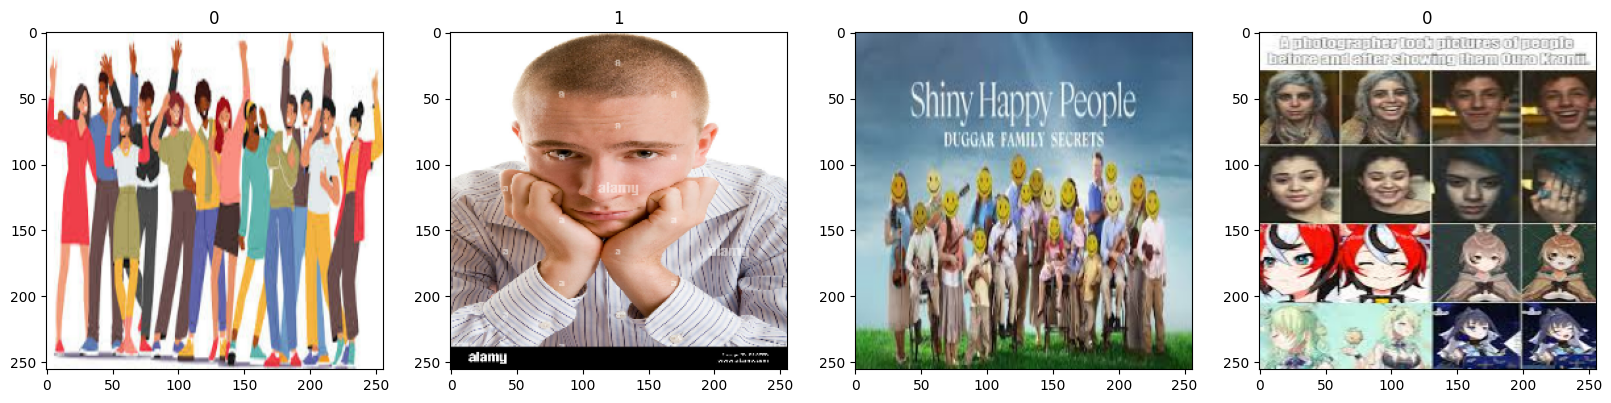

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [8]:
data = data.map(lambda x,y: (x/255, y))


In [9]:
data.as_numpy_iterator().next()


(array([[[[5.66482842e-02, 2.13541668e-02, 1.45526964e-03],
          [1.08946078e-01, 7.36519620e-02, 4.62009795e-02],
          [1.71254590e-01, 1.35960475e-01, 1.08509496e-01],
          ...,
          [4.36305135e-01, 4.54457730e-01, 5.26057005e-01],
          [4.42700684e-01, 4.62308526e-01, 5.40303290e-01],
          [4.43137258e-01, 4.62745100e-01, 5.41176498e-01]],
 
         [[1.14663817e-01, 7.93697014e-02, 5.51490039e-02],
          [1.57068819e-01, 1.21774696e-01, 9.43237171e-02],
          [2.07740039e-01, 1.72445923e-01, 1.44994944e-01],
          ...,
          [4.49770212e-01, 4.67922807e-01, 5.39522052e-01],
          [4.54171389e-01, 4.73779231e-01, 5.49779654e-01],
          [4.56519037e-01, 4.76126879e-01, 5.54474950e-01]],
 
         [[1.97183430e-01, 1.61889315e-01, 1.34438336e-01],
          [2.24435881e-01, 1.89141750e-01, 1.61690772e-01],
          [2.54940808e-01, 2.19646692e-01, 1.92195714e-01],
          ...,
          [4.70176727e-01, 4.89246309e-01, 5.5809

In [10]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [11]:
train_size

10

In [12]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [13]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [15]:
model = Sequential()


In [16]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/home/somya/Image Classifier/my_tf_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [18]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
logsdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logsdir)

In [20]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


I0000 00:00:1742023477.367480   25376 service.cc:152] XLA service 0x7f5d38005f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742023477.367623   25376 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-03-15 03:24:37.971662: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742023478.362048   25376 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4236 - loss: 1.5995

I0000 00:00:1742023482.206252   25376 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4604 - loss: 1.3677

2025-03-15 03:24:43.197303: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.4642 - loss: 1.3063 - val_accuracy: 0.5521 - val_loss: 0.6912
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.5782 - loss: 0.6901 - val_accuracy: 0.6146 - val_loss: 0.6872
Epoch 3/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6562 - loss: 0.6813

2025-03-15 03:24:45.330621: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5787 - loss: 0.6852

2025-03-15 03:24:46.195503: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.5775 - loss: 0.6847 - val_accuracy: 0.4583 - val_loss: 0.7400
Epoch 4/20
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5409 - loss: 0.6804

2025-03-15 03:24:47.359784: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.5482 - loss: 0.6802 - val_accuracy: 0.6146 - val_loss: 0.6741
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.5990 - loss: 0.6665 - val_accuracy: 0.7188 - val_loss: 0.6471
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.6179 - loss: 0.6521 - val_accuracy: 0.7188 - val_loss: 0.6186
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.7603 - loss: 0.5953 - val_accuracy: 0.7083 - val_loss: 0.5603
Epoch 8/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5938 - loss: 0.6179

2025-03-15 03:24:50.617934: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.6186 - loss: 0.6330 - val_accuracy: 0.6354 - val_loss: 0.5881
Epoch 9/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7812 - loss: 0.4927

2025-03-15 03:24:51.759817: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7637 - loss: 0.5293

2025-03-15 03:24:52.618934: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.7622 - loss: 0.5296 - val_accuracy: 0.7917 - val_loss: 0.4539
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.7625 - loss: 0.4889 - val_accuracy: 0.8750 - val_loss: 0.3786
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.8513 - loss: 0.4006 - val_accuracy: 0.8854 - val_loss: 0.3596
Epoch 12/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8125 - loss: 0.4232

2025-03-15 03:24:54.985366: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8268 - loss: 0.4161 - val_accuracy: 0.8125 - val_loss: 0.3860
Epoch 13/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8125 - loss: 0.4041

2025-03-15 03:24:55.866187: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.8299 - loss: 0.4017 - val_accuracy: 0.9062 - val_loss: 0.3159
Epoch 14/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9688 - loss: 0.2483

2025-03-15 03:24:56.869102: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9259 - loss: 0.2489 - val_accuracy: 0.9479 - val_loss: 0.1866
Epoch 15/20


2025-03-15 03:24:57.866768: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9464 - loss: 0.2079 - val_accuracy: 0.9479 - val_loss: 0.2207
Epoch 16/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 0.1149

2025-03-15 03:24:58.841395: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9460 - loss: 0.1724 - val_accuracy: 0.9479 - val_loss: 0.1239
Epoch 17/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9375 - loss: 0.2450

2025-03-15 03:24:59.816434: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9463 - loss: 0.1988 - val_accuracy: 0.9896 - val_loss: 0.1210
Epoch 18/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9674 - loss: 0.1217 - val_accuracy: 0.9792 - val_loss: 0.0810
Epoch 19/20
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0672

2025-03-15 03:25:01.841257: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9879 - loss: 0.0796 - val_accuracy: 0.9896 - val_loss: 0.1085
Epoch 20/20


2025-03-15 03:25:02.887504: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9694 - loss: 0.0935 - val_accuracy: 0.9583 - val_loss: 0.1104


2025-03-15 03:25:03.949347: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166080 bytes after encountering the first element of size 25166080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


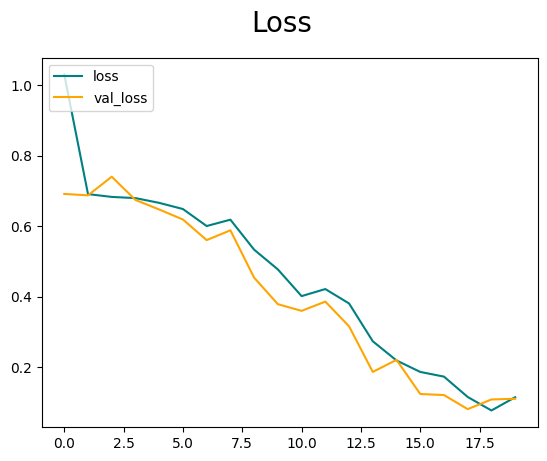

In [21]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

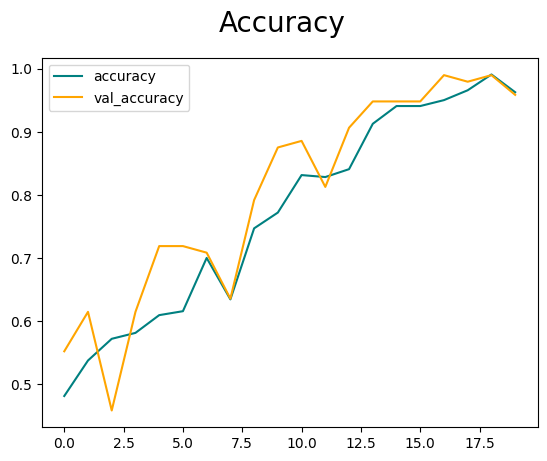

In [22]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [23]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


In [24]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print(pre.result(), re.result(), acc.result())

2025-03-15 03:25:04.758242: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 41940480 bytes after encountering the first element of size 41940480 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
tf.Tensor(0.88235295, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9375, shape=(), dtype=float32)


2025-03-15 03:25:05.494482: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


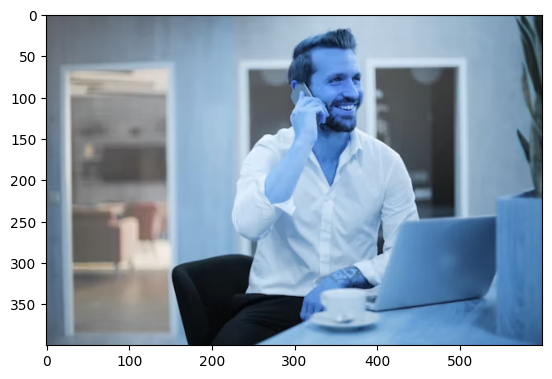

In [46]:
img = cv2.imread('test_image.png')
plt.imshow(img)
plt.show()

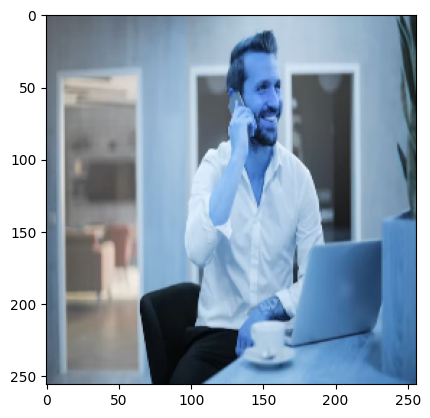

In [47]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [48]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


array([[0.14647035]], dtype=float32)

In [49]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy
